In [1]:
!pip install keras-tuner
!pip install joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import tensorflow as tf
from keras.src.models import Sequential
from keras.src.layers import (Dense, Dropout, BatchNormalization)
from keras.src.optimizers import Adam
from keras_tuner import Hyperband, RandomSearch
from keras import regularizers
import joblib
from google.colab import drive

### Mount Google Drive

In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/capstone_2_airbnb/AB_NYC_2019.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


### Initial Data Exploration

In [4]:
print("\n=== Initial Data Exploration ===")
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nData Summary:")
display(df.describe(include='all').T)

print("\nMissing Values:")
missing = df.isna().sum()
display(missing[missing > 0])


=== Initial Data Exploration ===
Dataset Shape: (48895, 16)

First 5 rows:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0



Data Summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,48895.0,NaN,NaN,NaN,19017143.23618,10983108.38561,2539.0,9471945.0,19677284.0,29152178.5,36487245.0
name,48879,47905,Hillside Hotel,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,48895.0,NaN,NaN,NaN,67620010.64661,78610967.032667,2438.0,7822033.0,30793816.0,107434423.0,274321313.0
host_name,48874,11452,Michael,417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group,48895,5,Manhattan,21661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood,48895,221,Williamsburg,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,48895.0,NaN,NaN,NaN,40.728949,0.05453,40.49979,40.6901,40.72307,40.763115,40.91306
longitude,48895.0,NaN,NaN,NaN,-73.95217,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
room_type,48895,3,Entire home/apt,25409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,48895.0,NaN,NaN,NaN,152.720687,240.15417,0.0,69.0,106.0,175.0,10000.0



Missing Values:


,0
name,16
host_name,21
last_review,10052
reviews_per_month,10052


### Data Preparation

In [5]:
def prepare_data(df):
    # Basic cleaning
    df = df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)
    df = df[df['price'].between(df['price'].quantile(0.01), df['price'].quantile(0.99))]

    # Feature engineering
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    df['log_price'] = np.log1p(df['price'])
    df['room_neighborhood'] = df['room_type'] + "_" + df['neighbourhood_group']

    return df.drop('price', axis=1)

# Apply preprocessing
processed_df = prepare_data(df.copy())

### Post-Processing Exploration

In [6]:
print("\n=== Processed Data Exploration ===")
display(processed_df.describe().T)
display(processed_df.isna().sum())


=== Processed Data Exploration ===


,count,mean,std,min,25%,50%,75%,max
latitude,48017.0,40.729006,0.054380,40.499790,40.69017,40.722990,40.763160,40.913060
longitude,48017.0,-73.952161,0.045990,-74.244420,-73.98296,-73.955650,-73.936460,-73.712990
minimum_nights,48017.0,6.969844,20.295359,1.000000,1.00000,3.000000,5.000000,1250.000000
number_of_reviews,48017.0,23.471604,44.781426,0.000000,1.00000,5.000000,24.000000,629.000000
reviews_per_month,48017.0,1.096605,1.601323,0.000000,0.04000,0.380000,1.600000,58.500000
calculated_host_listings_count,48017.0,7.199763,33.213516,1.000000,1.00000,1.000000,2.000000,327.000000
availability_365,48017.0,112.073224,131.220142,0.000000,0.00000,44.000000,224.000000,365.000000
log_price,48017.0,4.725938,0.634943,3.433987,4.26268,4.663439,5.170484,6.684612


,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
minimum_nights,0
number_of_reviews,0
reviews_per_month,0
calculated_host_listings_count,0
availability_365,0


### Predictive Power Analysis


=== Numerical Features Correlation with Price ===


,calculated_host_listings_count,availability_365,latitude,minimum_nights,number_of_reviews,reviews_per_month,longitude
log_price,0.148973,0.089724,0.080734,0.026004,-0.037208,-0.051446,-0.330604



=== Categorical Features Analysis ===


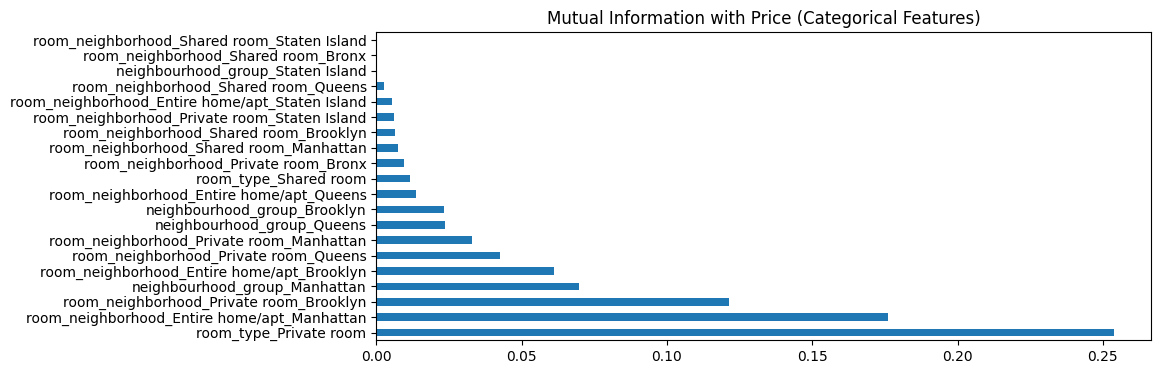

In [11]:
# Numerical feature correlation
print("\n=== Numerical Features Correlation with Price ===")
correlation = processed_df.corr(numeric_only=True)['log_price'].sort_values(ascending=False)
display(pd.DataFrame(correlation.iloc[1:]).T)

# Categorical feature analysis
print("\n=== Categorical Features Analysis ===")
categorical_cols = ['neighbourhood_group', 'room_type', 'room_neighborhood']
cat_dummies = pd.get_dummies(processed_df[categorical_cols], drop_first=True)
mi = mutual_info_regression(cat_dummies, processed_df['log_price'], random_state=42)
mi_scores = pd.Series(mi, index=cat_dummies.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 4))
mi_scores.plot(kind='barh')
plt.title('Mutual Information with Price (Categorical Features)')
plt.show()

### Basic EDA

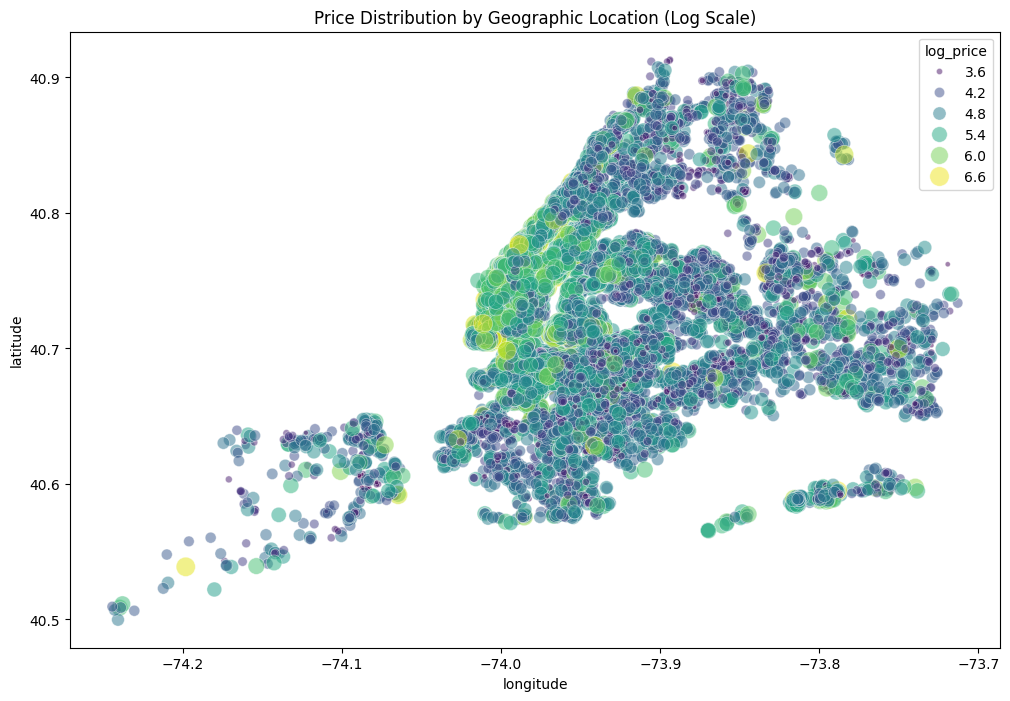

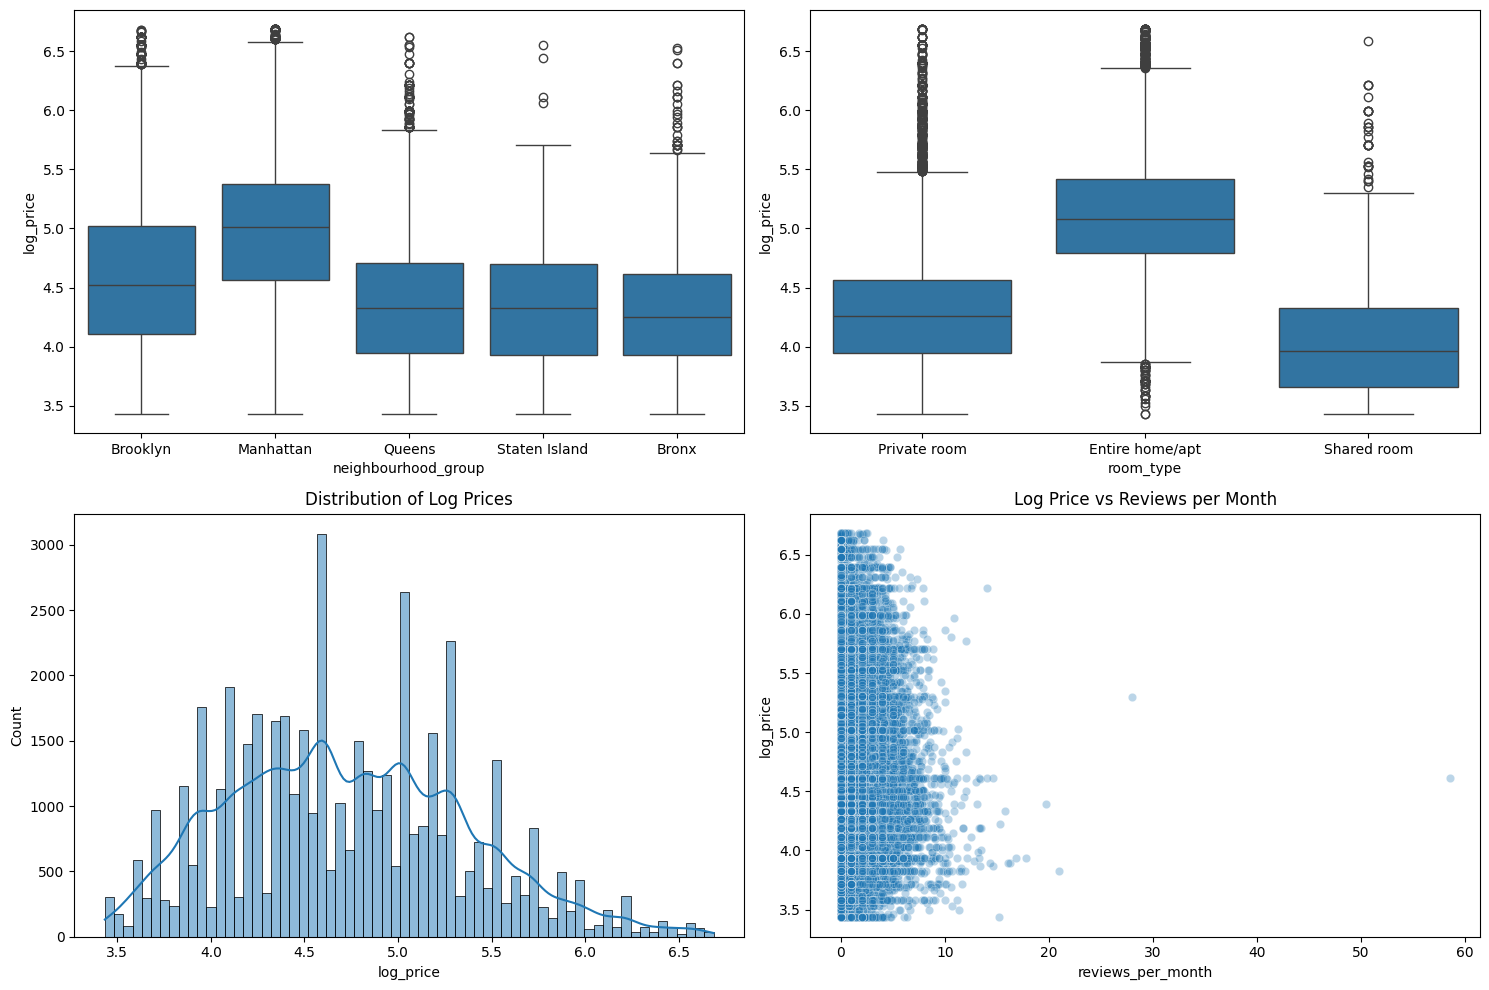

In [9]:
# Geospatial visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', hue='log_price', size='log_price', sizes=(10, 200), alpha=0.5, palette='viridis', data=processed_df)
plt.title('Price Distribution by Geographic Location (Log Scale)')
plt.show()

# Price by category and numerical features
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='neighbourhood_group', y='log_price', data=processed_df, ax=ax[0, 0])
sns.boxplot(x='room_type', y='log_price', data=processed_df, ax=ax[0, 1])
sns.histplot(processed_df['log_price'], kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Log Prices')
sns.scatterplot(x='reviews_per_month', y='log_price', data=processed_df, ax=ax[1, 1], alpha=0.3)
ax[1, 1].set_title('Log Price vs Reviews per Month')
plt.tight_layout()
plt.show()

### Train/Test Split, Feature Configuration, Data Preparation

In [13]:
# Train/Test Split
train_df, test_df = train_test_split(processed_df, test_size=0.2, random_state=42)

# Feature Configuration
numerical_features = ['latitude', 'longitude', 'minimum_nights',
                     'number_of_reviews', 'reviews_per_month',
                     'calculated_host_listings_count', 'availability_365']

categorical_features = ['neighbourhood_group', 'room_type', 'room_neighborhood']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Prepare data
X_train = preprocessor.fit_transform(train_df.drop('log_price', axis=1))
X_test = preprocessor.transform(test_df.drop('log_price', axis=1))
y_train = train_df['log_price'].values
y_test = test_df['log_price'].values

### Model Building

In [14]:
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=64),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5)))

    # Hidden layer
    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=32),
        activation='relu'
    ))

    # Output layer
    model.add(Dense(1))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 1e-3])),
        loss='mse',
        metrics=['mae']
    )
    return model


### Hyperparameter Tuning

In [15]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='airbnb_tuning',
    project_name='price_prediction'
)

tuner.search(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=256,
    verbose=1
)

Trial 10 Complete [00h 00m 15s]
val_loss: 0.1640903353691101

Best val_loss So Far: 0.1640903353691101
Total elapsed time: 00h 02m 47s


### Finding best model

In [17]:
best_model = tuner.get_best_models(num_models=1)[0]


history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2274 - mae: 0.3677 - val_loss: 0.1808 - val_mae: 0.3363 - learning_rate: 0.0010
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2277 - mae: 0.3703 - val_loss: 0.1700 - val_mae: 0.3108 - learning_rate: 0.0010
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2165 - mae: 0.3577 - val_loss: 0.1666 - val_mae: 0.3145 - learning_rate: 0.0010
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2108 - mae: 0.3549 - val_loss: 0.1634 - val_mae: 0.3057 - learning_rate: 0.0010
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2112 - mae: 0.3531 - val_loss: 0.1656 - val_mae: 0.3068 - learning_rate: 0.0010
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2035 - mae: 0.3478 - val_loss: 0.1725 - val_mae: 0.3112 - learning_rate: 0.0010
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2081 - mae: 0.3504 - val_loss: 0.1680 - val_mae: 0.3058 - learning_rate: 0.0010
Epoch 8/50
121/1

### Evaluation

In [18]:

test_predictions = best_model.predict(X_test).flatten()
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test Performance:")
print(f"MAE (log scale): {test_mae:.4f}")
print(f"RMSE (log scale): {test_rmse:.4f}")
print(f"R² Score: {r2:.4f}")

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Final Test Performance:
MAE (log scale): 0.3026
RMSE (log scale): 0.4003
R² Score: 0.6050


### Convert back to original scale

In [19]:
original_prices = np.expm1(y_test)
predicted_prices = np.expm1(test_predictions)

print("\nMetrics in Original USD Scale:")
print(f"MAE: ${mean_absolute_error(original_prices, predicted_prices):.2f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(original_prices, predicted_prices)):.2f}")


Metrics in Original USD Scale:
MAE: $45.15
RMSE: $80.67


### Save model and preprocessor

In [20]:

model_path = '/content/drive/MyDrive/Colab Notebooks/capstone_2_airbnb/optimized_model.h5'
best_model.save(model_path)
joblib.dump(preprocessor, model_path + '_preprocessor.pkl')
print("\nModel and preprocessor saved successfully!")


Model and preprocessor saved successfully!
